In [91]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

## Proprecessing

In [92]:
train_dataset = pd.read_csv("cs-training.csv", index_col = 0) #150000
test_dataset = pd.read_csv("cs-test.csv", index_col = 0) #101503
train_dataset.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [93]:
# 对于 'age' 列，仅将等于0的值替换为中位数
median_age = train_dataset['age'].median()
train_dataset.loc[train_dataset['age'] == 0, 'age'] = median_age

In [94]:
# 记录缺失值的填补参数
MonthlyIncome_para = train_dataset['MonthlyIncome'].median()
NumberOfDependents_para = train_dataset['NumberOfDependents'].mode().iloc[0]
train_dataset.fillna({'MonthlyIncome': MonthlyIncome_para}, inplace=True)
train_dataset.fillna({'NumberOfDependents': NumberOfDependents_para}, inplace=True)
print(MonthlyIncome_para,NumberOfDependents_para)

5400.0 0.0


In [95]:
X, y = train_dataset.iloc[:, 1:].values, train_dataset.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [96]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## PCA

In [97]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.299693  , 0.15439554, 0.12423053, 0.10228981, 0.10015169,
       0.09109736, 0.07155781, 0.05427837, 0.00165273, 0.00065316])

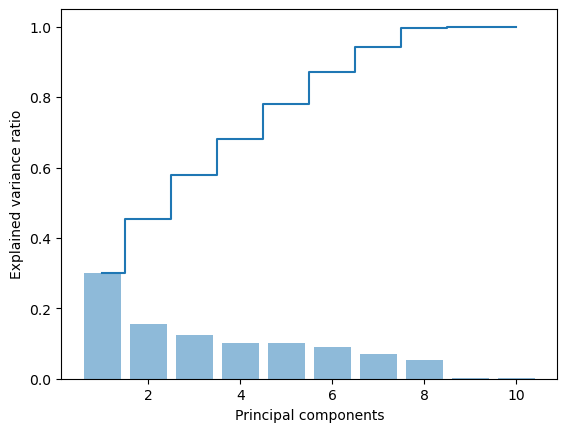

In [98]:
plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 11), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [99]:
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
pca.explained_variance_ratio_

array([0.299693  , 0.15439554, 0.12423053, 0.10228981, 0.10015169,
       0.09109736])

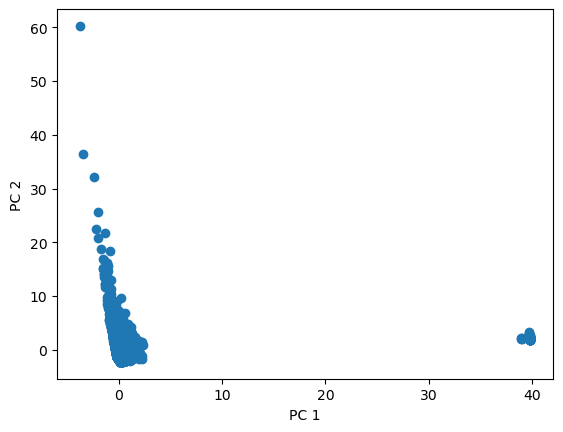

In [100]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

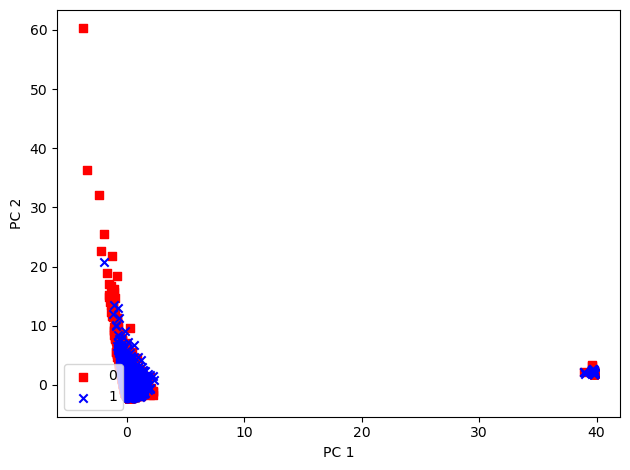

In [101]:
colors = ['r', 'b']
markers = ['s', 'x']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

## Pipeline

### lr

Fold: 1, Class dist.: [78407  5593], Acc: 0.934
Fold: 2, Class dist.: [78407  5593], Acc: 0.933
Fold: 3, Class dist.: [78407  5593], Acc: 0.934
Fold: 4, Class dist.: [78407  5593], Acc: 0.933
Fold: 5, Class dist.: [78408  5592], Acc: 0.934

CV accuracy: 0.934 +/- 0.000


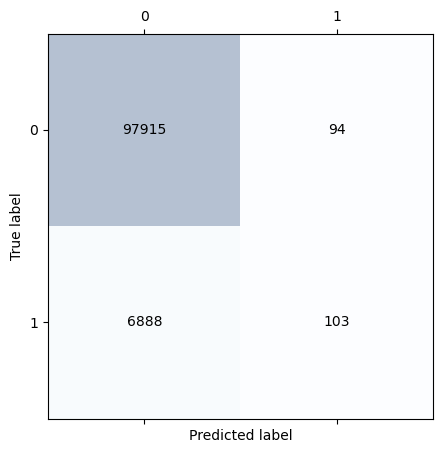

In [102]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=6)),
                    ('clf', LogisticRegression(random_state=1))])

kfold = StratifiedKFold(n_splits=5).split(X_train, y_train)
conf_mat = np.zeros((2, 2))

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)

    # 预测测试集
    y_pred = pipe_lr.predict(X_train[test])
    # 计算混淆矩阵并累加
    conf_mat += confusion_matrix(y_train[test], y_pred)
    
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
     
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# 绘制混淆矩阵
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=int(conf_mat[i, j]), va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


### svm

In [104]:
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=6)),
                     ('clf', SVC(random_state=1))])

param_range = [0.01, 0.1, 1, 10, 100]

param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': param_range, 
                  'clf__gamma': param_range, 
                  'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

# 绘制混淆矩阵
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()